In [1]:
import kagglehub

path = kagglehub.dataset_download("yasserh/avengers-faces-dataset")

print("Path to dataset files:", path)

100%|██████████| 89.6M/89.6M [00:00<00:00, 132MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yasserh/avengers-faces-dataset/versions/1


In [2]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/yasserh/avengers-faces-dataset/versions/1"


for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")


1/
    images/
        val/
            chris_evans/
                chris_evans39.png
                chris_evans32.png
                chris_evans30.png
                chris_evans31.png
                chris_evans35.png
                chris_evans36.png
                chris_evans37.png
                chris_evans29.png
                chris_evans38.png
                chris_evans49.png
                chris_evans33.png
                chris_evans48.png
            chris_hemsworth/
                chris_hemsworth15.png
                chris_hemsworth14.png
                chris_hemsworth8.png
                chris_hemsworth39.png
                chris_hemsworth34.png
                chris_hemsworth28.png
                chris_hemsworth32.png
                chris_hemsworth29.png
                chris_hemsworth13.png
                chris_hemsworth33.png
                chris_hemsworth53.png
                chris_hemsworth35.png
            mark_ruffalo/
                mark_ruffalo6

In [3]:
import os

# Correct base path (no extra "1/")
base_path = "/root/.cache/kagglehub/datasets/yasserh/avengers-faces-dataset/versions/1/images"

splits = ["train", "val", "test"]

for split in splits:
    print(f"\n=== {split.upper()} SET ===")
    split_path = os.path.join(base_path, split)
    total_split = 0

    for cls in os.listdir(split_path):
        class_path = os.path.join(split_path, cls)
        if os.path.isdir(class_path):
            img_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            total_split += img_count
            print(f"{cls}: {img_count} images")

    print(f"Total {split} images: {total_split}")



=== TRAIN SET ===
chris_evans: 50 images
chris_hemsworth: 53 images
mark_ruffalo: 66 images
robert_downey_jr: 51 images
scarlett_johansson: 54 images
Total train images: 274

=== VAL SET ===
chris_evans: 12 images
chris_hemsworth: 12 images
mark_ruffalo: 12 images
robert_downey_jr: 12 images
scarlett_johansson: 12 images
Total val images: 60

=== TEST SET ===
chris_evans: 12 images
chris_hemsworth: 12 images
mark_ruffalo: 12 images
robert_downey_jr: 12 images
scarlett_johansson: 12 images
Total test images: 60


In [4]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

base_path = "/root/.cache/kagglehub/datasets/yasserh/avengers-faces-dataset/versions/1/images"
splits = ["train", "val", "test"]


IMG_SIZE = (100, 100)


In [5]:
def load_dataset(split_path, img_size=(100,100)):
    X, y = [], []
    label_map = {}
    current_label = 0

    for cls in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, cls)
        if not os.path.isdir(class_path):
            continue
        if cls not in label_map:
            label_map[cls] = current_label
            current_label += 1
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            try:
                img = Image.open(fpath).convert("L")  # grayscale
                img = img.resize(img_size)
                arr = np.asarray(img, dtype=np.float64).ravel()
                X.append(arr)
                y.append(label_map[cls])
            except Exception as e:
                print(f"Error reading {fpath}: {e}")
    return np.array(X), np.array(y), label_map


X_train, y_train, label_map = load_dataset(os.path.join(base_path, "train"), IMG_SIZE)
X_val, y_val, _ = load_dataset(os.path.join(base_path, "val"), IMG_SIZE)
X_test, y_test, _ = load_dataset(os.path.join(base_path, "test"), IMG_SIZE)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)
print("Labels:", label_map)


Train: (274, 10000) (274,)
Val: (60, 10000) (60,)
Test: (60, 10000) (60,)
Labels: {'chris_evans': 0, 'chris_hemsworth': 1, 'mark_ruffalo': 2, 'robert_downey_jr': 3, 'scarlett_johansson': 4}


In [12]:
def compute_pca(X, k):

    N, d = X.shape
    mean_face = np.mean(X, axis=0)
    Xc = X - mean_face


    L = np.dot(Xc, Xc.T) / N
    vals, vecs = np.linalg.eigh(L)
    idx = np.argsort(vals)[::-1]
    vals, vecs = vals[idx], vecs[:, idx]


    vals, vecs = vals[:k], vecs[:, :k]


    eigvecs = np.dot(Xc.T, vecs)
    eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)

    return mean_face, eigvecs.T, vals


k = 100
mean_face, eigenfaces, eigvals = compute_pca(X_train, k)
print("Eigenfaces shape:", eigenfaces.shape)


Eigenfaces shape: (100, 10000)


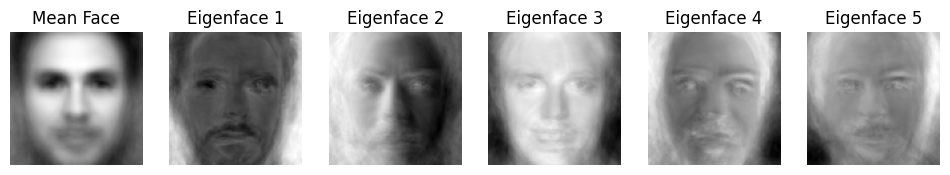

In [13]:
def show_image(vector, img_size, title=""):
    plt.imshow(vector.reshape(img_size), cmap="gray")
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(12,4))
plt.subplot(1,6,1)
show_image(mean_face, IMG_SIZE, "Mean Face")

for i in range(5):
    plt.subplot(1,6,i+2)
    show_image(eigenfaces[i], IMG_SIZE, f"Eigenface {i+1}")
plt.show()


In [14]:
def project(X, mean, eigenfaces):
    Xc = X - mean
    return np.dot(Xc, eigenfaces.T)

X_train_proj = project(X_train, mean_face, eigenfaces)
X_val_proj   = project(X_val, mean_face, eigenfaces)
X_test_proj  = project(X_test, mean_face, eigenfaces)

print("Projected shapes:", X_train_proj.shape, X_val_proj.shape, X_test_proj.shape)


Projected shapes: (274, 100) (60, 100) (60, 100)


In [15]:
from sklearn.metrics import accuracy_score, classification_report

def nearest_neighbor(X_train_proj, y_train, X_proj):
    preds = []
    for x in X_proj:
        dists = np.linalg.norm(X_train_proj - x, axis=1)
        idx = np.argmin(dists)
        preds.append(y_train[idx])
    return np.array(preds)


y_val_pred = nearest_neighbor(X_train_proj, y_train, X_val_proj)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


y_test_pred = nearest_neighbor(X_train_proj, y_train, X_test_proj)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc*100:.2f}%")


inv_map = {v:k for k,v in label_map.items()}
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=[inv_map[i] for i in sorted(inv_map.keys())]))


Validation Accuracy: 100.00%
Test Accuracy: 100.00%

Classification Report (Test Set):
                    precision    recall  f1-score   support

       chris_evans       1.00      1.00      1.00        12
   chris_hemsworth       1.00      1.00      1.00        12
      mark_ruffalo       1.00      1.00      1.00        12
  robert_downey_jr       1.00      1.00      1.00        12
scarlett_johansson       1.00      1.00      1.00        12

          accuracy                           1.00        60
         macro avg       1.00      1.00      1.00        60
      weighted avg       1.00      1.00      1.00        60



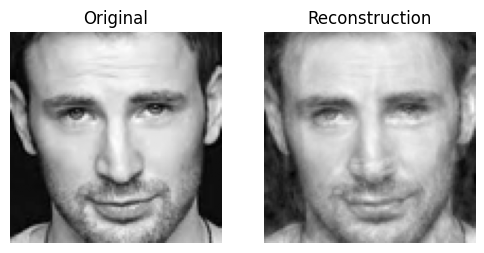

In [16]:
def reconstruct(X_proj, mean, eigenfaces):
    return np.dot(X_proj, eigenfaces) + mean

idx = 0  # pick a sample index
orig = X_test[idx]
proj = X_test_proj[idx]
recon = reconstruct(proj.reshape(1,-1), mean_face, eigenfaces)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
show_image(orig, IMG_SIZE, "Original")
plt.subplot(1,2,2)
show_image(recon, IMG_SIZE, "Reconstruction")
plt.show()
